In [38]:
import glob
import os
import sys

from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM

sys.path.append(f"{os.getcwd()}/../")
from src.models.utils.preprocessing import get_shadow_light_gt

%matplotlib inline

In [2]:
# get all directories in data/SIAR
paths = glob.glob(f"{os.getcwd()}/../data/SIAR/*")
paths[0]

'/Users/boris/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/4. Semester/CV_Project/decomposition_learning/notebooks/../data/SIAR/1069'

In [3]:
ssim_metric = SSIM(return_full_image=True)

/Users/boris/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/4. Semester/CV_Project/decomposition_learning/venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [63]:
def display_grid(img, img_bw, sl, sl_bw, ssim):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    ax[0, 0].imshow(img)
    ax[0, 0].set_title("Original Image")
    ax[0, 0].axis("off")
    ax[0, 1].imshow(img_bw, cmap="gray")
    ax[0, 1].set_title("Original Image (BW)")
    ax[0, 1].axis("off")
    ax[1, 0].imshow(sl)
    ax[1, 0].set_title("Shadow and Light Image")
    ax[1, 0].axis("off")
    ax[1, 1].imshow(sl_bw, cmap="gray")
    ax[1, 1].set_title("Shadow and Light Image (BW)")
    ax[1, 1].axis("off")
    ax[0, 2].imshow(ssim, cmap="gray")
    ax[0, 2].set_title("SSIM")
    ax[0, 2].axis("off")
    ax[1, 2].axis("off")

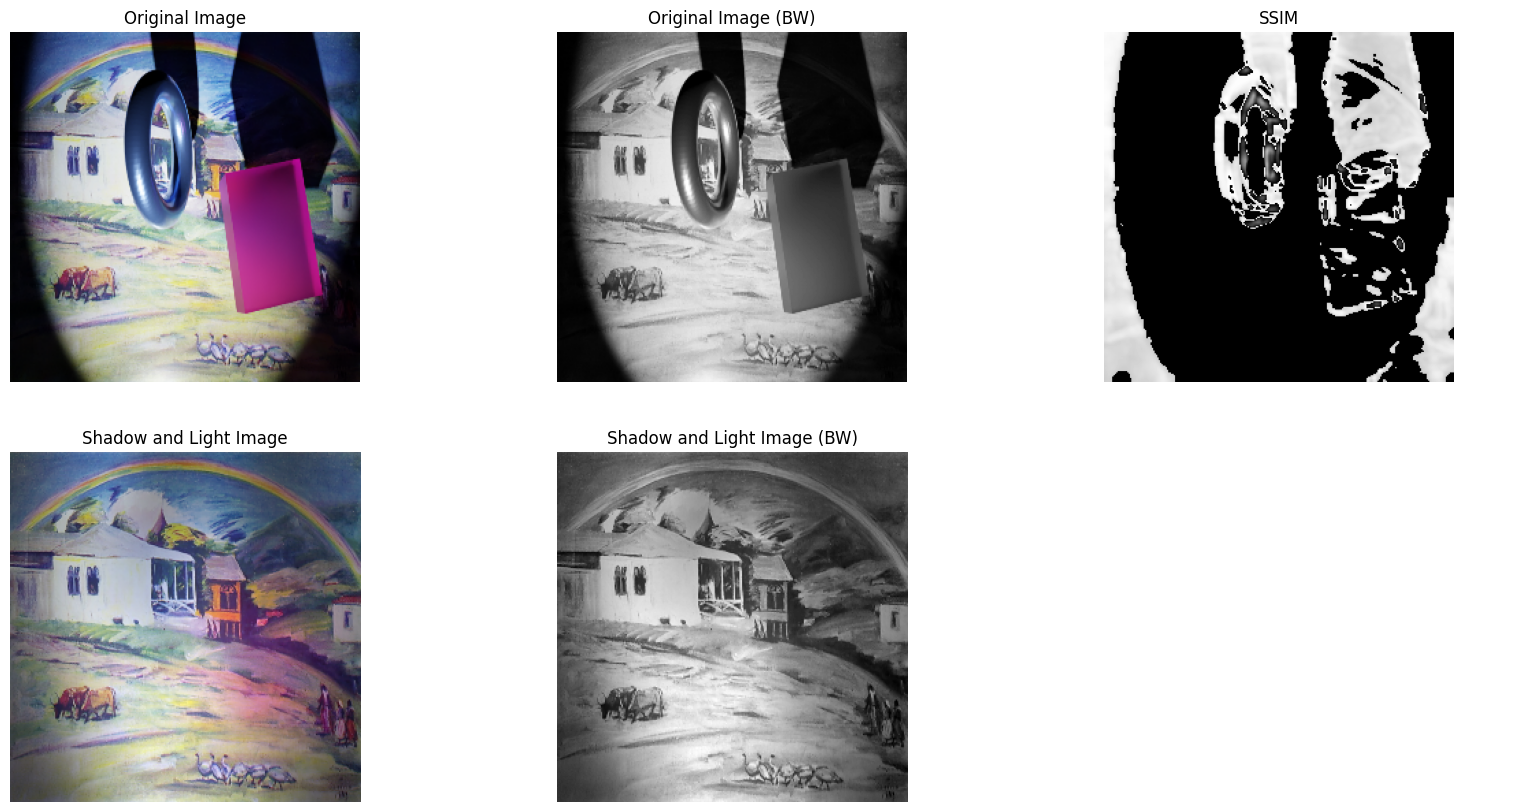

In [104]:
for sequence in paths:
    # get all images in sequence
    images = glob.glob(f"{sequence}/*.png")
    # sort images
    images.sort()

    # get the last image, which is the gt
    gt = images[-1]
    # remove the last image, which is the gt
    images = images[:-1]

    transform = transforms.Compose([transforms.PILToTensor()])
    toGrayscale = transforms.Grayscale()
    toPIL = transforms.ToPILImage()

    # read the images and gt and convert to numpy arrays
    images_PIL = [Image.open(x) for x in images]
    images = [transform(x) for x in images_PIL]
    images = torch.stack(images).swapaxes(0, 1)

    gt = transform(Image.open(gt))

    # get images without occlusions (gt with shadow and light only)
    sl_images = get_shadow_light_gt(gt, images)
    sl_images_PIL = [transforms.ToPILImage()(x) for x in sl_images.swapaxes(0, 1)]

    # show all images in a grid
    # ger random images
    # idx = torch.randint(0, images.shape[1], (1,))


    # --- Experiment settings ---
    idx = torch.tensor([7]) # 5 is cool, 8 is difficult and 7 is even more difficult
    normalize = False
    divide_by_255 = True
    grayscale = True
    segmentation_threshold = 0.8
    # ---------------------------

    for i in range(images.shape[1]):
        i=idx.item()

        img = images[:, i, :, :].unsqueeze(0).type(torch.FloatTensor) # img.mean() ~ 140 (or in that order of magnitude)!!
        sl = sl_images[:, i, :, :].unsqueeze(0).type(torch.FloatTensor) # sl.mean() ~ 0.5 (or in that order of magnitude)!!

        if divide_by_255:
            # --- Experiment 1 ---
            # devide by 255
            img = img / 255.0

        if normalize:
            # --- Experiment 2 ---
            # normalize img and sl
            img = (img - img.min()) / (img.max() - img.min())
            sl = (sl - sl.min()) / (sl.max() - sl.min())

        if grayscale:
            # --- Experiment 3 ---
            # Directly improves SSIM but ***needs*** Experiment 1 or 2, both yield similar results
            # convert to dtype float
            img = toGrayscale(img)
            sl = toGrayscale(sl)

        # compute patchwise SSIM
        # ssim = ssim_metric(img, sl)
        ssim = ssim_metric(sl, img)
        ssim_img = ssim[1].squeeze(0)
        #invert ssim_img
        ssim_img = 1 - ssim_img
        # threshold ssim_img
        ssim_img[ssim_img < segmentation_threshold] = 0


        # --- Visualize ---
        # ssim tensor to PIL
        ssim_PIL = toPIL(ssim_img)

        # img tensor to PIL
        img_PIL = images_PIL[i]
        img_PIL_bw = toPIL(img.squeeze(0))
        sl_PIL = sl_images_PIL[i]
        sl_PIL_bw = toPIL(sl.squeeze(0))

        display_grid(img_PIL, img_PIL_bw, sl_PIL, sl_PIL_bw, ssim_PIL)
        # -----------------
        break

    break